# [NTDS'17] assignment 1: Solution
[ntds'17]: https://github.com/mdeff/ntds_2017

[Effrosyni Simou](http://lts4.epfl.ch/simou), [EPFL LTS4](http://lts4.epfl.ch)

# Objective of Exercise
The aim of this exercise is to learn how to create your own, real network using data collected from the Internet and then to discover some properties of the collected network. 

# Resources
You might want to have a look at the following resources before starting:

* [Twitter REST API](https://dev.twitter.com/rest/public)
* [Tweepy Documentation](http://tweepy.readthedocs.io/en/v3.5.0/)
* [Tutorial "Mining Twitter data with Python"](https://marcobonzanini.com/2015/03/02/mining-twitter-data-with-python-part-1/)

# 1. Collect a Twitter Network

In order to collect data from Twitter you will need to generate access tokens.  To do this you will need to register a [client application with Twitter](https://apps.twitter.com/). Once you are done you should have your tokens. You can now create a `credentials.ini` file as follows:
```
[twitter]
consumer_key = YOUR-CONSUMER-KEY
consumer_secret = YOUR-CONSUMER-SECRET
access_token = YOUR-ACCESS-TOKEN
access_secret = YOUR-ACCESS-SECRET
```
In this way you will have this information readily available to you. 

In [1]:
%matplotlib inline

import random
import configparser
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import tweepy  # you will need to install tweepy first

In [2]:
# Read the confidential token.
credentials = configparser.ConfigParser()
credentials.read('credentials.ini')

#authentication
auth = tweepy.OAuthHandler(credentials.get('twitter', 'consumer_key'), credentials.get('twitter', 'consumer_secret'))
auth.set_access_token(credentials.get('twitter', 'access_token'), credentials.get('twitter', 'access_secret'))

#construct API instance
#deal with rate limits and notify when delayed because of rate limits
api = tweepy.API(auth,wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

Now you are all set up to start collecting data from Twitter! 

In this exercise we will construct a network with the following logic:

1) We will chose a `user_id` in Twitter to be our first node. 

2) We will find (some) of the users who are both following `user_id` and are being followed by `user_id`. From now on we will call such users "connections" of `user_id`. We will place these user ids in a list called `first_nodes`. 

3) For every node in the list `first_nodes` we will then find (some) of the users who are following and are being followed by this node (aka the connections of this node). The user ids collected in this step will be placed in a list called `second_nodes`.

4) The collection of the ids of all nodes (aka Twitter users) that we have collected so far will be placed in a list called `all_nodes`.

5) Since we have only collected a subset of all possible "connections" for our nodes we have to check if there are any remaining inner connections that we have missed.

The entire network is to be organized in a dictionary with entries that will have as key the Twitter id of the user (this is a number characterizing each user in Twitter) and as value the list of ids of his connections.

So, let us begin. The first thing that you will have to do is to chose the node from which everything will start. I have chosen the Twitter account of [Applied Machine Learning Days](https://www.appliedmldays.org) that will take place in January 2018 in EPFL. You may change that if you wish to, but please make sure that the user you chose has both followers and friends and that he allows you to access this data.

In [3]:
user = 'appliedmldays '
user_id=api.get_user(user).id

In the following cell write a function that takes as an argument the Twitter id of a user and returns a list with the **ids** of his connections. Take into account the case where a user does not allow you to access this information.

**Reminder:** By connections we mean users that are both followers and friends of a given user.

In [4]:
def find_connections(user_id):
    followers = []
    friends = []
    try:
        for page in tweepy.Cursor(api.followers_ids, user_id).pages():
            followers = followers + page 
        for page in tweepy.Cursor(api.friends_ids, user_id).pages():
            friends = friends + page 
        connections = list(set(friends).intersection(followers))
    except tweepy.TweepError: #raise exception when you cannot access the followers of a user
        # we get a tweep error when we can't view a user - skip them and move onto the next.
            print('Could not view user {}, skipping...'.format(user_id))
            connections = ['null']
    return connections

In [5]:
first_connections = find_connections(user_id)
print('{}has {} connections'.format(user, len(first_connections)))

appliedmldays has 141 connections


Collect your `first_nodes` and `second_nodes` and organize your collected nodes and their connections in the dictionary called `network`.

Hints:
* Use `random.choice([1,3,4])` to randomly choose a number in `[1, 3, 4]`.
* Use the `append` and `remove` methods to add and remove an element from a Python list.
* The `pop` method removes the last item in the list.

In [6]:
network = {}
first_nodes = []
second_nodes = []
how_many = 10#This is the number of connections you are sampling. 
          #Keep small (e.g.3) for development, larger later (e.g. 10)
n = min(how_many,len(first_connections))
i=0
while (i in range(0,n))&(first_connections != []):
    current_id = random.choice(first_connections)
    # remove the ID from the list, so we don't pick it again.
    first_connections.remove(current_id)
    first_nodes.append(current_id)
    second_connections = find_connections(current_id)
    '''avoid collecting: 
       i) protected users as first nodes 
       ii) nodes that are already collected in the second_nodes list as first nodes''' 
    if (second_connections==['null'])|(current_id in second_nodes):
        first_nodes.pop()
        print(i)
        continue
    else:
        network[current_id] = []
        j=0
        m = min(how_many,len(second_connections))
        while (j in range(0,m))&(second_connections != []):
            new_current_id = random.choice(second_connections)
            # remove the ID from the list, so we don't pick it again.
            second_connections.remove(new_current_id)
            second_nodes.append(new_current_id)
            third_connections = find_connections(new_current_id)
            '''avoid collecting: 
               i) protected users as second nodes 
               ii) the root node as a second node
               ii) nodes that have already been collected in the first_nodes list as second nodes'''
            if (third_connections==['null'])|(new_current_id==user_id)|(new_current_id in first_nodes):
                second_nodes.pop()
            else:
                network[current_id].append(new_current_id)
                j=j+1
    
    if user_id not in network[current_id]:
        network[current_id].append(user_id) #make sure to include the root in the connections of the first nodes
    print(i)
    i = i+1

0
Rate limit reached. Sleeping for: 862
Rate limit reached. Sleeping for: 895
Rate limit reached. Sleeping for: 895
Could not view user 530950089, skipping...
Could not view user 716623862, skipping...
Rate limit reached. Sleeping for: 890
1
Rate limit reached. Sleeping for: 895
Could not view user 19888273, skipping...
Could not view user 232974417, skipping...
2
Could not view user 51738744, skipping...
Rate limit reached. Sleeping for: 864
Rate limit reached. Sleeping for: 894
3
Rate limit reached. Sleeping for: 895
Could not view user 19066345, skipping...
4
Rate limit reached. Sleeping for: 878
Rate limit reached. Sleeping for: 896
5
Rate limit reached. Sleeping for: 896
6
Rate limit reached. Sleeping for: 890
Rate limit reached. Sleeping for: 895
Rate limit reached. Sleeping for: 896
Could not view user 227423290, skipping...
7
Could not view user 404075638, skipping...
Rate limit reached. Sleeping for: 870
8
Rate limit reached. Sleeping for: 878
9


**Be careful!** You should only keep a small value for the `how_many` parameter while you are developing your code. In order to answer to the questions you should raise the value of this parameter to `how_many=10` at least. This will take a while to execute because of the API rate limit (plan your time accordingly). You should also remember to submit your jupyter notebook with the **output shown for a large value of the `how_many` parameter**. 

In [7]:
network[user_id] = first_nodes

In [8]:
pprint(network)

{382393: [15308423,
          1008442225,
          355626264,
          29694990,
          700746896680161280,
          5439642,
          155636227,
          861230886,
          24414798,
          21695487,
          763052115392593920],
 14177696: [2564697607,
            381054288,
            487673211,
            13348402,
            2258911,
            559966263,
            900843938,
            14704764,
            2815170184,
            3656369897,
            763052115392593920],
 22403036: [15106933,
            206719125,
            1408838665,
            167056343,
            299757170,
            3240168873,
            20191120,
            353925814,
            73039079,
            49580432,
            763052115392593920],
 335986035: [9704802,
             2234372946,
             22425612,
             317637840,
             69726522,
             2505279536,
             907581515240034305,
             790266440582434816,
             3036329200,

In [9]:
s = network.values()
nodes = set(val for dic in s for val in dic) 
second_nodes = list(set(second_nodes)) #remove possible duplicates from second nodes
all_nodes = list(nodes)

In [10]:
print('There are {} first hop nodes'.format(len(first_nodes)))
print('There are {} second hop nodes'.format(len(second_nodes)))
print('There are overall {} nodes in the collected network'.format(len(all_nodes)))

There are 10 first hop nodes
There are 88 second hop nodes
There are overall 99 nodes in the collected network


In [11]:
# Initialize the dictionary entries for the second nodes 
for i in second_nodes:
    network[i] = []

Find the inner connections between your collected nodes that you might have missed because you sampled the connections.

In [12]:
for i in range(0,len(all_nodes)):
    current_id = all_nodes[i]
    connections = find_connections(current_id)
    inner_connections = []+list(set(connections).intersection(set(all_nodes)))
    network[current_id] = list(set(network[current_id]+inner_connections))
    print(i)
    print(len(inner_connections))

0
13
1
2
2
1
3
8
4
6
5
8
6
4
7
1
8
2
9
1
10
11
Rate limit reached. Sleeping for: 878
11
1
12
1
13
5
14
5
15
6
16
1
17
1
18
2
19
2
20
2
21
2
22
11
Rate limit reached. Sleeping for: 864
23
2
24
1
25
4
26
7
27
1
28
2
29
1
30
1
31
2
32
1
33
1
34
6
35
10
36
10
37
1
Rate limit reached. Sleeping for: 857
38
2
39
2
40
4
Rate limit reached. Sleeping for: 896
41
9
42
1
43
1
44
1
45
6
Rate limit reached. Sleeping for: 881
46
2
47
7
48
5
49
1
50
2
51
5
52
1
53
1
54
1
55
5
56
5
57
1
58
3
59
3
Rate limit reached. Sleeping for: 872
60
4
61
3
62
2
63
1
64
3
65
1
66
2
67
2
68
4
69
1
70
11
71
1
72
2
73
2
74
11
Rate limit reached. Sleeping for: 878
75
2
Rate limit reached. Sleeping for: 896
76
4
77
7
Rate limit reached. Sleeping for: 896
78
3
79
1
80
1
81
15
82
1
83
1
84
1
85
2
86
17
87
3
88
1
89
2
90
1
91
14
Rate limit reached. Sleeping for: 875
92
2
93
1
94
1
95
2
Rate limit reached. Sleeping for: 897
96
4
97
1
98
1


# 2. Discover some of the properties of the collected network

## 2.1 Adjacency matrix

Congradulations! You have now created a dictionary that describes a real Twitter network!
We now want to transform this dictionary into the adjacency (or weight) matrix that you learned about in your first class. 

In [13]:
W = np.zeros([len(all_nodes),len(all_nodes)], dtype=int)

In [14]:
sorted_nodes = sorted(list(network.keys()))
weights = {}
for i in range(0,len(sorted_nodes)):
    current_id = sorted_nodes[i]
    weights[current_id] = sorted(network[current_id])


In [15]:
for i in range(0,len(sorted_nodes)):
    current_id = sorted_nodes[i]
    #print(current_id)
    my_list = weights[current_id]
    #print(my_list)
    for j in my_list:
        #print(j)
        W[i,sorted_nodes.index(j)] = 1
        W[sorted_nodes.index(j),i] = 1
        

Remember that a weight matrix should be symmetric. Check if it is:

In [16]:
np.nonzero(W-W.transpose())

(array([], dtype=int64), array([], dtype=int64))

**Question 1:**
It might happen that $W \neq W^{T} $ for some $(i,j)$. Explain why this might be the case.

**Your answer here:**

Your weight matrix could be non-symmetric if:

* You had not chosen all of your collected nodes to be non-protected users.
* You had not used the Cursor object in order to collect all the connections of the nodes.

In this implementation, the weight matrix is created in such a way that it will always be symmetric.

Impose your weight matrix to be symmetric.

In [17]:
# Make W is symmetric
bigger = W.transpose() > W

In [18]:
W = W - W*bigger + W.transpose()*bigger

Plot the weight matrix of your collected network.

Hint: use `plt.spy()` to visualize a matrix.

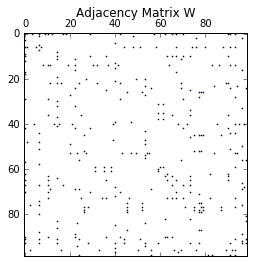

In [19]:
plt.spy(W, markersize=1)
plt.title('Adjacency Matrix W')

**Question 2:**
What is the maximum number of links $L_{max}$ in a network with $N$ nodes (where $N$ is the number of nodes in your collected network)? How many links $L$ are there in your collected network? Comment on how $L$ and $L_{max}$ compare.

In [20]:
L = W.sum()/2

In [21]:
print(L)

176.0


**Your answer here:** The maximum number of links in a network with $N$ nodes is $L_{max}=N(N-1)/2$. This will be the case of a complete graph. Therefore, the maximum number of links for a network with $N=99$ nodes will be $L_{max}=4851$. The number of links in the collected network is $L=176$. We can see that $L << L_{max}$ and therefore we can conclude that the network is very sparse $L=O(N)$. 

## 2.2 Degrees distribution

Plot a histogram of the degree distribution. 

In [22]:
d = W.sum(axis=0)

In [23]:
print(d)

[17  2  2  1  1  1 15  1  1  1 10  3  1  1 14  1  2  2  1  1  3  1  9  3  5
  2  5  2  2  4  1  2  2  1  1  2  5  1  2  2 11  1  5  1  3  6  1  2  2  2
  1  2  4 11  1  1  4  1  1  6  1  4  4  5  1  7  1  7  2  5  6  1  1 11  1
  4  3 10  7  4  1  1  2  2  2  1  1  3  1  2  8  8  1 13  2  1 11  2  6]


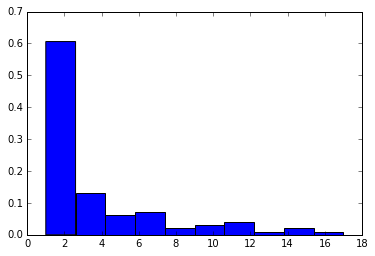

In [24]:
weights = np.ones_like(d)/float(len(all_nodes))
plt.hist(d, weights = weights);

**Question 3:** Comment on the plot. What do you observe? Would you expect a similar degree disribution in the complete Twitter network?

**Your answer here:** We observe that the majority of the nodes in the collected network have a degree equal to 1. This is not the case for the whole Twitter network, but it is a result of the way that we collected the network. 

However, we can see that the network seems to have a degree distribution of a scale-free network, i.e. the degree distribution follows a power law. This will become more apparent as the value of the parameter ``how_many`` increases.

## 2.3 Average degree

Calculate the average degree of your collected network.

In [25]:
d_avg = np.sum(d)/len(d)

In [26]:
print(d_avg)

3.55555555556


## 2.4 Diameter of the collected network

**Question 4:** What is the diameter of the collected network? Please justify.

**Your answer here:** The diameter is by definition the longest shortest path between two nodes in a network. 

Because of the way that we constructed the network, the longest possible paths are between two nodes of the list ``second_nodes``. 

Specifically, the path between any two nodes in the list ``second_nodes`` can be as in the following cases A, B, C and D :

Case A:
second node -> first node -> root -> first node -> second node

Therefore, the length of the shortest path in this case will be equal to 4.

Case B:
It may happen that some of the first nodes will be connected and therefore the path between some of the second nodes will be:

second node -> first node -> first node -> second node

Therefore, the length of the shortest path in this case will be equal to 3.

Case C:
Some of the second nodes will obviously be connected through the same first node and therefore the path between them will be:

second node -> first node -> second node

Therefore, the length of the shortest path in this case will be equal to 2.

Case D:
Also it might happen that some of the second nodes will be directly connected to one another and therefore the path between those two second nodes will be second node -> second node.

Therefore, the length of the shortest path in this case will be equal to 1.

However, as we saw in Question 2, the collected network is very sparse and therefore at least one pair of second nodes will exist such that the shortest path between them is equal to 4. As a result, the diameter of the network will be $d=4$.

## 2.5 Pruning the collected network

You might notice that some nodes have very few connections and hence our matrix is very sparse. Prune the collected network so that you keep only the nodes that have a degree that is greater than the average degree and plot the new adjacency matrix.

In [27]:
Wpruned = W[d>d_avg][:,d>d_avg]

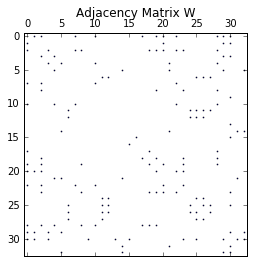

In [28]:
plt.spy(Wpruned, markersize=1)
plt.title('Adjacency Matrix W');